# 1. ガウス過程回帰モデル

## 1.1 Introduction

ガウス過程回帰モデルを用いれば、説明変数 $x$ と被説明変数 $y$ の両方を観測したデータ点を複数個準備することで、$y\mid x$ の確率分布を推定することができます。ガウス過程回帰モデルではベイズ推論を行っていて、確率分布の推定には予測分布を用いています。

<center><img src="./imgs/gauss_process.png" width=350px><br>Fig 1. ガウス回帰モデルの結果のイメージ</center>

特筆すべき課題として、スケーラビリティが必要なときは簡単ではない工夫が必要なこと・モデルが解釈可能性を持たないことが挙げられます。

**解説の流れ** : 1.2節では、ガウス過程回帰モデルのイメージを、`GPy` パッケージを用いたデモを通してつかんでみましょう。1.3節では、ガウス過程回帰モデルの仕組みを数学を用いて説明します。1.4節では、ガウス過程回帰モデルとはなんだったかをまとめ、触れられなかった話題について手短に紹介します。

In [5]:
import sys
sys.path

['/Users/gonakazawa/Documents/go/dev_environments/bayes_optimization',
 '/opt/homebrew/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python310.zip',
 '/opt/homebrew/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10',
 '/opt/homebrew/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload',
 '',
 '/opt/homebrew/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages',
 '/opt/homebrew/opt/six/lib/python3.10/site-packages',
 '/opt/homebrew/lib/python3.10/site-packages']

In [6]:
sys.path.append("/Users/gonakazawa/.pyenv/versions/3.10.6/lib/python3.10/site-packages")

In [8]:
!pip install matplotlib
!pip install GPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 12.0 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 14.7 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 9.3 MB/s eta 0:00:0031m10.3 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.3/987.3 kB 18.4 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 15.5 MB/s eta 0:00:00m eta 0:00:010:01:01
  DEPRECATION: paramz is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 

In [12]:
import pandas as pd
data = pd.DataFrame()

In [9]:
# import文
import numpy as np
import matplotlib.pyplot as plt

# pip install GPy
import GPy

## 1.2 デモ

### 1.2.1 ガウス過程

ガウス過程は関数の確率分布です。

**定義** : $m(x)$を関数, $K(x,x')$ をカーネル関数とします。関数 $f(x)$ が、どんな正の整数 $n$ と実数 $x_{1},x_{2},\cdots,x_{n}$ に対しても、

\begin{align*}
\begin{pmatrix}f(x_1)\\f(x_2)\\\vdots\\f(x_n)\end{pmatrix}
&\sim N\left(
\begin{pmatrix}m(x_1)\\m(x_2)\\\vdots\\m(x_n)\end{pmatrix},
\begin{pmatrix}
K(x_1,x_1)&K(x_1,x_2)&\cdots&K(x_1,x_n)\\
K(x_2,x_1)&K(x_2,x_2)&\cdots&K(x_2,x_n)\\
\vdots&\vdots&\ddots &\cdots\\
K(x_n,x_1)&K(x_n,x_2)&\cdots&K(x_n,x_n)\\
\end{pmatrix}
\right)
\end{align*}

が成り立つとき、関数 $f(x)$ はガウス過程に従っているといい、$f\sim GP(m,K)$ と書きます。$m$を平均関数といいます。カーネル関数には

* RBFカーネル
* Matern 3/2カーネル、Martern 5/2カーネル

などがあり、関数のなめらかさを制御することができます。

#### RBFカーネル

$$
\begin{align*}
k(x, x') &= \sigma^2\exp\left(-\frac{\|x-x'\|^2}{2}\right)
\end{align*}
$$

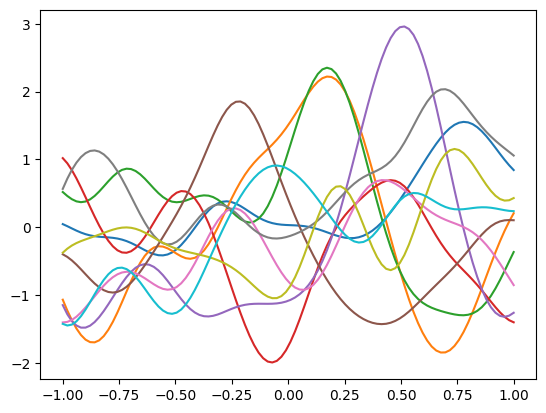

In [10]:
# RBFカーネル
rbf = GPy.kern.RBF(input_dim = 1, variance = 1.0, lengthscale = 0.2)

x_sim = np.linspace(start = -1, stop = 1, num = 100)[:, np.newaxis]

mu = np.zeros(100)    # 平均関数m
cov = rbf.K(x_sim, x_sim)    # カーネル関数が定める分散共分散行列
y_sim = np.random.multivariate_normal(mu, cov, size = 10)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(10):
    ax.plot(x_sim.reshape(-1), y_sim[i, :])

#### Matern 3/2カーネル

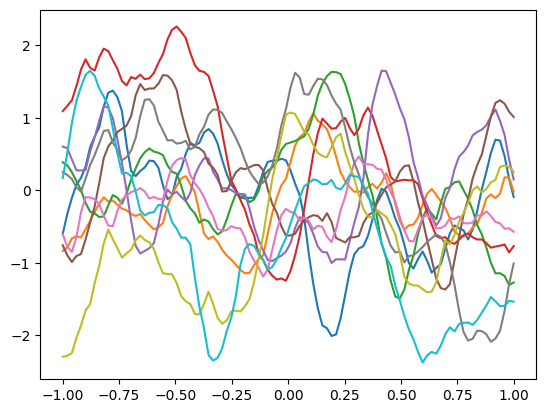

In [13]:
# Matern 3/2カーネル
matern32 = GPy.kern.Matern32(input_dim = 1, variance = 1.0, lengthscale = 0.2)

x_sim = np.linspace(start = -1, stop = 1, num = 100)[:, np.newaxis]

mu = np.zeros(100)    # 平均関数m
cov = matern32.K(x_sim, x_sim)    # カーネル関数が定める分散共分散行列
y_sim = np.random.multivariate_normal(mu, cov, size = 10)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(10):
    ax.plot(x_sim.reshape(-1), y_sim[i, :])

#### Matern 5/2カーネル

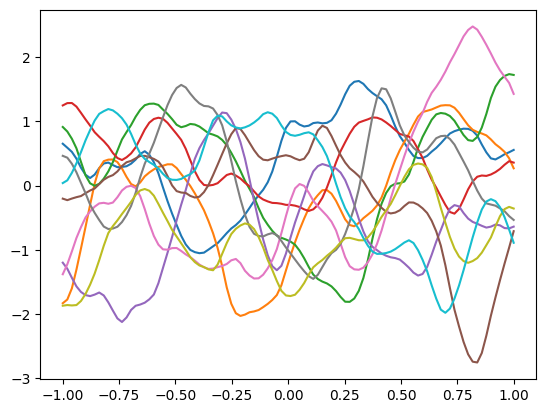

In [14]:
# Martern 5/2カーネル
matern52 = GPy.kern.Matern52(input_dim = 1, variance = 1.0, lengthscale = 0.2)

x_sim = np.linspace(start = -1, stop = 1, num = 100)[:, np.newaxis]

mu = np.zeros(100)    # 平均関数m
cov = matern52.K(x_sim, x_sim)    # カーネル関数が定める分散共分散行列
y_sim = np.random.multivariate_normal(mu, cov, size = 10)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(10):
    ax.plot(x_sim.reshape(-1), y_sim[i, :])

### 1.2.2 デモデータ

ガウス過程回帰モデルを用いた実験を行うことで、このモデルのイメージをつかんでみましょう。今回は、次のような実験を行います。

**実験** : サイズ $n=256$ の独立な標本 $(x_{1}, y_{1}),(x_{2}, y_{2}),\cdots, (x_{256},y_{256})$ を、以下のような確率分布からとります。ここで、$x_{1},x_{2},\cdots,x_{256}$ は固定された値であるとします。

\begin{align*}
y_{i} &= x_{i}\sin x_{i}+\epsilon_{i}\\
\epsilon_{i} &\sim N(0, 1)
\end{align*}

以下のグラフは、任意の $x$ の値について、$y\mid x$ の確率分布の期待値 $\mathbb{E}\left[y\mid x\right]=x\sin x$ と95%範囲 $x\sin x\pm 1.96$ を表したものです。

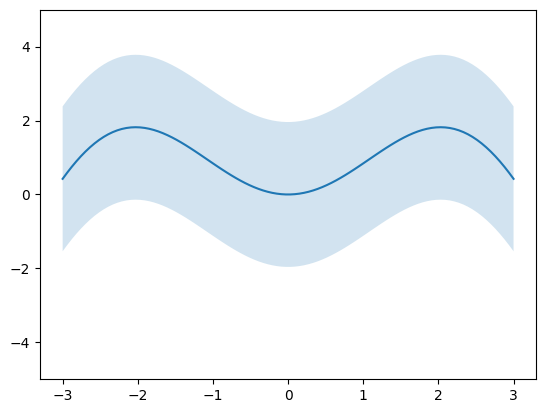

In [15]:
# 確率分布（予測分布の推定対象）
x = np.linspace(start = -3.0, stop = 3.0, num = 100)
y = x*np.sin(x)
plt.plot(x, y)
plt.fill_between(x, y + 1.96*1, y - 1.96*1, alpha = 0.2)
plt.ylim(-5, 5)
plt.show()

### 1.2.3 実験の準備

`numpy` パッケージを用いて、確率分布

\begin{align*}
y &= x\sin x+\epsilon\\
\epsilon &\sim N(0, 1)
\end{align*}

から、独立な標本を抽出するための `example` メソッドを実装します。

In [16]:
# 標本抽出に用いるメソッド
def example(size, seed = 1):
    np.random.seed(seed = seed)
    x = np.random.normal(size = size)
    y = x*np.sin(x) + np.random.normal(loc = 0.0, scale = 1.0, size = size)
    return x[:, np.newaxis], y

In [17]:
# 試しにサイズ 2の標本を抽出してみる。
example(size = 2)

(array([[ 1.62434536],
        [-0.61175641]]),
 array([ 1.09384526, -0.72163311]))

### 1.2.4 `GPy`を用いたガウス過程回帰モデルの計算

ガウス過程回帰モデルは、`GPy.models` モジュールの `GPRegression` クラスを用いて計算できます。今回のデモは、以下の手順で行います。

1. 標本を抽出する
2. カーネル関数を選択する。これは「関数の事前分布」を選択することに対応する。
3. `GPRegression` クラスのインスタンスを建てる。（特に `kernel` 引数に設計したカーネル関数を渡す。）
4. ハイパーパラメータを最適化する。（`optimize` メソッドを用いる。）
5. 事後分布を確認する（`posterior_sample`メソッドを用いる。）
6. 予測分布の期待値や分位点を求める。（`predict`メソッドを用いる。）

#### step 1. 標本を抽出する

1.2.1節で作った `example` メソッドを用いて、サイズ 256 の独立な標本を抽出しましょう。

In [18]:
# step 1. 標本を抽出する。
X_train, y_train = example(size = 256)

In [19]:
X_train.shape, y_train.shape

((256, 1), (256,))

#### step 2. カーネル関数を選択する

カーネル関数の選択は、ガウス過程回帰モデルにおいて「関数の事前分布」・「誤差の分散の値」を選択することに対応します。

In [20]:
# step 2. カーネル関数を選択する。
rbf = GPy.kern.RBF(input_dim = 1)

#### step 3. `GPRegression` クラスのインスタンスを建てる

`GPRegression` クラスの `kernel` 引数に、step 2で選択したカーネル関数を渡し、インスタンスを建てます。ここで`sklearn`とは異なり、インスタンスを建てる時点で入力と出力を与えること、出力は2次元配列で与えることに注意してください。

In [21]:
# step 3. ガウス過程回帰モデルのインスタンスを建て、事後分布を計算する。
gpr = GPy.models.GPRegression(X_train, y_train[:, np.newaxis], kernel = rbf)

なお、観測値に誤差がつかない場合は、ここで、

```
gpr.Gaussian_noise.constrain_fixed(1e-6, warning = False)
```

として、誤差の分散が$0$であることを明言しておきます。

#### step 4. ハイパーパラメータを最適化する

インスタンスの`optimize` メソッドを用いてハイパーパラメータを最適化します。これを第2種最尤推定といいます。

In [22]:
# step 4. ハイパーパラメータを最適化する
gpr.optimize()

#### step 5. 関数の事後分布を確認する

関数の事後分布から、どんな関数が得られるのかをサンプリングすることで、事後分布の様子を確認しましょう。

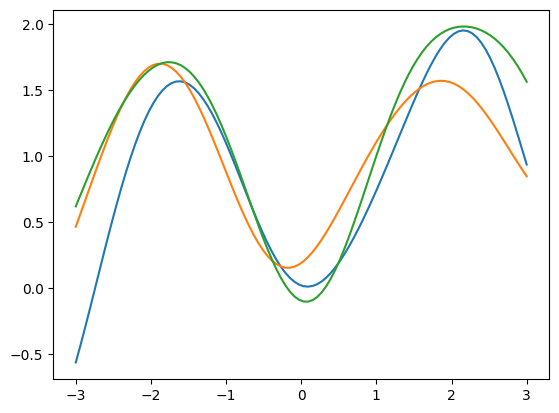

In [26]:
x_sim = np.linspace(start = -3, stop = 3, num = 100)[:, np.newaxis]

# mu =, cov=, y_sim = np.random.multivariate_normal(mu, cov, size)
y_sim = gpr.posterior_samples_f(x_sim, size = 3)
#↓は各点における出力値を、今得られている複数の事後分布からランダムに１つ選択し、出力するコード。よってなめらかな曲線にならず、ギザギザになっている。
#y_sim = gpr.posterior_samples(x_sim, size = 3)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(3):
    ax.plot(x_sim.reshape(-1), y_sim[:, :, i].reshape(-1))

#### step 6. 事後分布による予測分布を確認する

ガウス過程回帰モデルの予測分布は、事後分布を用いた場合にも、必ず正規分布になることが知られています。これもまた、1.3節で確認します。ゆえに、予測分布の95%区間は `[gp_exp-1.96*gp_std,gp_exp+1.96*gp_std]` であることが従います。以下のグラフは、この事実に基づいて、$y\mid x$ の予測分布の95%区間をグラフにしたものです。

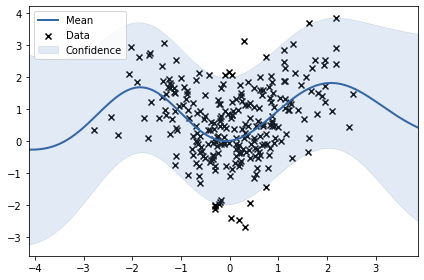

In [14]:
# step 5. 事後分布による予測分布の可視化
gpr.plot()
plt.show()

このグラフは、1.2節の冒頭で確認した確率分布のグラフに似ていることが確認できるでしょう。この結果は、ガウス過程回帰モデルによって計算された予測分布によって $y\mid x$ の確率分布がうまく推定できたことを意味しています。また、期待値と分散は`predict`メソッドによっても計算することができます。

In [15]:
# 予測値の計算
gpr_exp, gpr_var = gpr.predict(X_train)    # 期待値と分散

## 1.3 仕組み

説明変数 $x$ に対する被説明変数 $y$ の条件付き期待値 $\mathbb{E}\left[y\mid x\right]$ を回帰関数といいます。1.2節に実験では、$\mathbb{E}\left[y\mid x\right]=x\sin x$ が回帰関数でした。ガウス過程回帰モデルでは、次のような問題を考えます。

**問題** : サイズ $n$ の標本 $(x_1,y_1),(x_2,y_2),\cdots,(x_n,y_n)$ を以下の確率分布からとります。ただし、$x_1,x_2,\cdots,x_n$ は固定された値であるとします。

\begin{align*}
y_{i} = f(x_{i}) + \epsilon_i
\end{align*}

ただし、$f(x)$ は未知の関数、$\epsilon_i$ は期待値が $0$ かつ分散が $x$ の値によらず一定 $\sigma^2$ の正規分布に従う独立な確率変数、$\sigma^2$ は既知とします。定義から、$f(x)$ は回帰関数です。このとき、回帰関数 $f(x)$ のベイズ推定を行い、被説明変数の条件つき分布 $y\mid x$ の予測分布

\begin{align*}
\hat{p}(y\mid x) &= \int \phi(y;f(x),\sigma^2)post(f(x))df
\end{align*}

を求めなさい。ここで、$\phi(y;f(x),\sigma^2)$ は期待値が $f(x)$, 分散が $\sigma^2$ の正規分布の確率密度関数、$post$ は回帰関数の事後分布の密度関数です。

### 1.3.1  ガウス過程と事前分布

ガウス過程回帰モデルでは、関数の事前分布にガウス過程を敷きます。またこのことから「ガウス過程」回帰モデルという名前でよばれています。事前知識がなければ、$m(x)=0$ とするのが一般的です。ここではカーネル関数について、詳しく説明します。

1.2.2節のstep 2で行ったカーネル関数の選択は、このカーネル関数 $K(x,x')$ を定義している部分で

\begin{align*}
K(x,x') &= c\exp\left(-\frac{\|x-x'\|^2}{2\beta^2}\right)
\end{align*}

と定義されるカーネル関数です。これをRBFカーネル関数といいます。1.2節では、回帰関数の事前分布を

\begin{align*}
f&\sim GP\left(0, c\exp\left(-\frac{\|x-x'\|^2}{2\beta^2}\right)\right)
\end{align*}

と選択したことになります。

### 1.3.2 事前分布による $y\mid x$ の予測分布

1.3節の冒頭に掲げた問題設定で、誤差の分散 $\sigma^2$ の値は既知としたことに注意します。回帰関数 $f(x)$ の事前分布を $f\sim GP(m,K)$ と定義したので、

\begin{align*}
y\mid x &\sim f(x)+\epsilon
\end{align*}

から、$y\mid x$ の予測分布は $N(0,K(x,x)+\sigma^2)$ とわかります。

### 1.3.3 回帰関数の事後分布

ここで、新しく説明変数の値 $x$ を考えましょう。$f(x)$ の事後分布を求めます。$(f(x),y_1,y_2,\cdots,y_n)^T$ の同時分布は、

\begin{align*}
\begin{pmatrix}f(x)\\y_1\\\vdots\\y_n\end{pmatrix}
&\sim N\left(
\begin{pmatrix}m(x)\\m(x_1)\\\vdots\\m(x_n)\end{pmatrix},
\begin{pmatrix}
K(x,x)&K(x,x_1)&\cdots&K(x,x_n)\\
K(x_1,x)&K(x_1,x_1)+\sigma^2&\cdots&K(x_1,x_n)\\
\vdots&\vdots&\ddots &\cdots\\
K(x_n,x)&K(x_n,x_1)&\cdots&K(x_n,x_n)+\sigma^2\\
\end{pmatrix}
\right)
\end{align*}

です。ここで、多変量正規分布の条件付き分布の公式を用います。

**定理** : 以下が成り立つとき、$X_1\mid X_2=x_2\sim N(\mu_1+\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2), \Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21})$ が成り立つ。

\begin{align*}
\begin{pmatrix}X_1\\X_2\end{pmatrix}
&\sim N\left(
\begin{pmatrix}\mu_1\\\mu_2\end{pmatrix},
\begin{pmatrix}
\Sigma_{11}&\Sigma_{12}\\
\Sigma_{21}&\Sigma_{22}
\end{pmatrix}
\right)
\end{align*}

この公式から、$f(x)$ の事後分布は

\begin{align*}
f(x)\mid y_1,\cdots,y_n &\sim N\left(m(x)+k_n(x)^T(K_n+\sigma^2I)^{-1}(y-m_n), k(x,x)-k_n(x)^T(K_n+\sigma^2I)^{-1}k_n(x)\right)
\end{align*}

と求まります。ここで、$y=(y_1,\cdots,y_n)^T$, $m_n=(m(x_1),\cdots,m(x_n))^T$, $k_n(x)=(k(x,x_1),\cdots,k(x,x_n))^T$, $K_n=(k(x_i,x_j))_{i,j}$ です。1.1.2節のstep 5では、この計算を行なっています。

### 1.3.4 事後分布による $y\mid x$ の予測分布

1.3節の冒頭に掲げた問題設定で、誤差の分散 $\sigma^2$ の値は既知としたことに注意します。回帰関数 $f(x)$ の事後分布は $N\left(m(x)+k_n(x)^T(K_n+\sigma^2I)^{-1}(y-m_n), k(x,x)-k_n(x)^T(K_n+\sigma^2I)^{-1}k_n(x)\right)$ なので、

\begin{align*}
y\mid x &\sim f(x)+\epsilon
\end{align*}

から、$y\mid x$ の予測分布は 

\begin{align*}
N\left(m(x)+k_n(x)^T(K_n+\sigma^2I)^{-1}(y-m_n), k(x,x)-k_n(x)^T(K_n+\sigma^2I)^{-1}k_n(x)+\sigma^2\right)
\end{align*}

とわかります。1.2節 step 6の `predict` メソッドは期待値として $m(x)+k_n(x)^T(K_n+\sigma^2I)^{-1}(y-m_n)$、分散として $k(x,x)-k_n(x)^T(K_n+\sigma^2I)^{-1}k_n(x)+\sigma^2$ を返します。

**演習** : 1.2節の実験で、標本のサイズを $n=1$ にしたとします。 $(x_{1},y_{1})$ を得たとき、事後分布による $y\mid x=x_{1}$ の予測分布の標準偏差を求めてください。

**解答** : RBFカーネルは $k(x_1,x_1)=1$ です。また、$\sigma^2=1$ と設定したので、予測分布の標準偏差は $\sqrt{3/2}\sim1.225$ になります。

## 1.4 まとめと補足

### 1.4.1 まとめ

ガウス過程回帰モデルは、回帰関数の事前分布にガウス過程を敷き、ベイズ更新することで事後分布を得て、特に $y\mid x$ の予測分布を得る方法でした。

### 1.4.2 補足1 : ハイパーパラメータの最適化

$y\mid x$ の予測分布は、次のように具体的に与えられます。

\begin{align*}
N\left(m(x)+k_n(x)^T(K_n+\sigma^2I)^{-1}(y-m_n), k(x,x)-k_n(x)^T(K_n+\sigma^2I)^{-1}k_n(x)+\sigma^2\right)
\end{align*}

そこで、この分布の尤度が最大になるようにハイパーパラメータ `length_scale`, `noise_level` を決めることができます。これを **第2種最尤推定**といいます。`GPy` パッケージでは、`optimize`メソッドによって、L-BGFS-Bアルゴリズムで尤度関数を最大化します。

なお、第2種最尤推定は過剰適合を引き起こす可能性があるため、PAC-Bayesian定理をヒントにハイパーパラメータを探索するPAC-ガウス過程回帰モデルが提案されています。興味のある方は、Reeb, Doerr, Gerwinn and Rakitsch (NeurIPS 2018 accepted) を読んでみてください。

### 1.4.2 補足2 : 計算複雑度に関する議論

1.3.4節から、$y\mid x$ の予測分布を求めるためには、行列 $K$ をメモリに記録し、また行列 $K+\sigma^2I$ の逆行列を計算する必要があります。従って、訓練データのサイズ $N$ に対して空間計算量は $O(N^2)$、時間計算量は $O(N^3)$ です。特に後者の時間計算量を解決する案については、2通りの方法が検討されています。

* Sparse Gaussian Process : 標本サイズより少ない補助的なデータでベイズ推論することで予測分布を近似する。
* GPNet : 関数空間上でガウス過程を近似するニューラルネットワークをミニバッチ学習する。

興味のある方はそれぞれ、Cheng and Boots (NeurIPS 2016) および Shi, Khan and Zhu (ICML 2019) を読んでみてください。

### 1.4.3 補足3 :  モデルが解釈可能性を持たない点

ガウス過程回帰モデルは、解釈可能性を持ちません。例えば、線形回帰やロジスティック回帰のように偏回帰係数を解釈したり、決定木モデルなどのように変数重要度を確認したりすることができません。